[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rinax\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rinax\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rinax\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



--- NMF Topics ---
Topic 0: research database, database, academic, research, limited, limited access, access
Topic 1: food, cantine offer, cafeteria, cantine, offer option, offer, option
Topic 2: workload, health care, care, academic, mental, mental health, health
Topic 3: university, career, internship job, internship, job opportunity, opportunity, job
Topic 4: difficulty, material, online class, course material, online, course, class
Topic 5: sport program, culture, sport team, program, team, university, sport
NMF Coherence Score: 0.7812444272690596



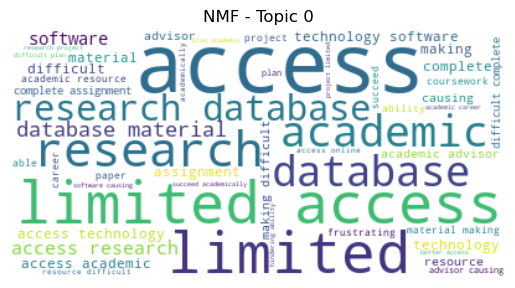

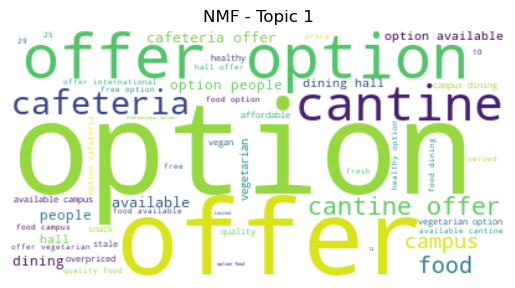

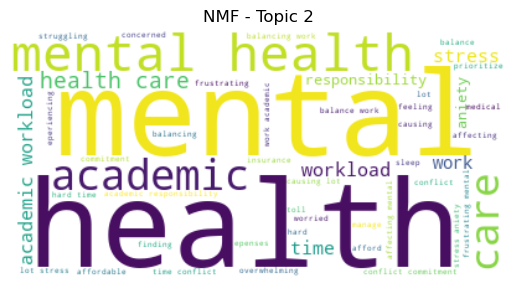

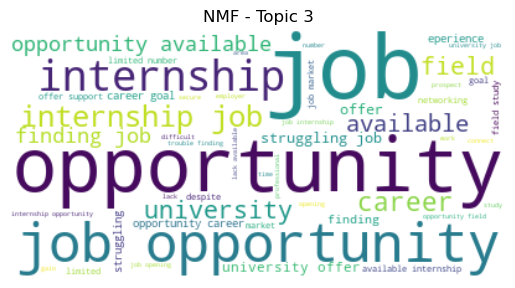

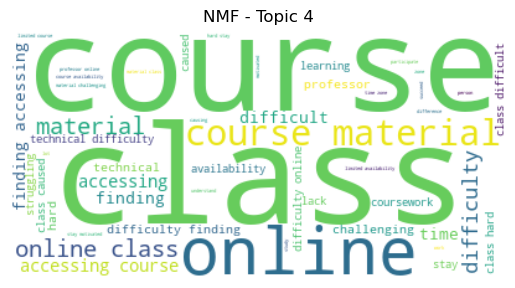

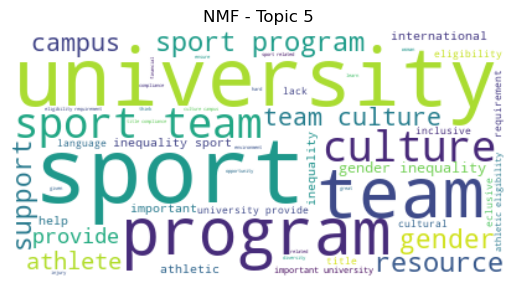

In [16]:
import pandas as pd
import re
import nltk
import spacy
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

# First downloading necessary NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load spaCy model for POS tagging
nlp = spacy.load("en_core_web_sm")


# Loading & Preprocessing the  Data
data = pd.read_csv("../../Data analysis/data/Datasetprojpowerbi.csv")
flattened_data = pd.json_normalize(data.to_dict(orient="records"))
df_complaints = pd.DataFrame(flattened_data[flattened_data['Reports'] != '']['Reports'])
df_complaints = pd.DataFrame(df_complaints['Reports'].rename('Reports'))

# Preprocessing Functions
def clean_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()

def clean_placeholders(text):
    return re.sub(r'[Xx]+', '', text)

def lowercase_text(text):
    return text.lower()

lemmatizer = WordNetLemmatizer()
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]

def tokenize_text(text):
    return nltk.word_tokenize(text)

# Removing auxiliary verbs (AUX, MD) but keep useful adjectives like 'bad'.
def remove_unwanted_pos(tokens):
    
    doc = nlp(" ".join(tokens))
    filtered_tokens = [token.text for token in doc if token.pos_ not in ["AUX", "MD"]]
    return filtered_tokens

def preprocess_text(text):
    text = clean_whitespace(text)
    text = clean_placeholders(text)
    text = lowercase_text(text)
    tokens = tokenize_text(text)
    tokens = remove_stopwords(tokens)
    tokens = remove_unwanted_pos(tokens)  # Apply POS filtering
    tokens = lemmatize_tokens(tokens)
    return " ".join(tokens)

df_complaints['processed_text'] = df_complaints['Reports'].apply(preprocess_text)

# Tokenizing texts into lists of words and creating a dictionary for coherence evaluation
texts = [text.split() for text in df_complaints['processed_text']]
dictionary = Dictionary(texts)


# Reduce TF-IDF Filtering Intensity (Less Aggressive)
def filter_low_tfidf_words(texts, vectorizer):
    """
    Removes words with very low TF-IDF scores to keep only meaningful words.
    """
    tfidf_matrix = vectorizer.fit_transform(texts)
    feature_names = np.array(vectorizer.get_feature_names_out())

    # Compute average TF-IDF score per word
    word_tfidf_scores = np.asarray(tfidf_matrix.mean(axis=0)).flatten()

    # Set threshold: Remove bottom 5% of words based on TF-IDF scores
    threshold = np.percentile(word_tfidf_scores, 5)
    important_words = feature_names[word_tfidf_scores > threshold]

    # Convert back to text, keeping only important words
    filtered_texts = []
    for text in texts:
        filtered_words = [word for word in text.split() if word in important_words]
        filtered_texts.append(" ".join(filtered_words))

    return filtered_texts

# Apply TF-IDF filtering
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english", min_df=5, ngram_range=(1,2))
df_complaints["processed_text"] = filter_low_tfidf_words(df_complaints["processed_text"], vectorizer)


# Define & Train NMF Model
custom_stop_words = list(ENGLISH_STOP_WORDS.union({
    'need', 'make', 'pay', 'issue', 'problem', 'student', 'like', 'really', 'feel', 'wish'
}))

vectorizer = TfidfVectorizer(max_features=5000, stop_words=custom_stop_words, ngram_range=(1,2))
matrix = vectorizer.fit_transform(df_complaints['processed_text'])

nmf_model = NMF(n_components=6, random_state=42)
nmf_model.fit(matrix)


# Extract & Display Topics
def get_top_words(model, feature_names, n_top_words=7):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[-n_top_words:]]
        topics.append(top_features)
        print(f"Topic {topic_idx}: {', '.join(top_features)}")
    return topics

print("\n--- NMF Topics ---")
topics = get_top_words(nmf_model, vectorizer.get_feature_names_out())


# Compute Coherence Score
coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f"NMF Coherence Score: {coherence_score}\n")


# Visualize Topics (Word Clouds)
def create_topic_wordcloud(model, feature_names):
    for i, topic in enumerate(model.components_):
        top_indices = topic.argsort()[-50:]
        frequencies = {feature_names[j]: topic[j] for j in top_indices}
        wordcloud = WordCloud(background_color='white').generate_from_frequencies(frequencies)
        plt.figure()
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"NMF - Topic {i}")
        plt.show()

create_topic_wordcloud(nmf_model, vectorizer.get_feature_names_out())

